# San Diego Dining Concierge: Predictive Modeling & Analysis
**Assignment 2 - Recommender Systems**

## 1. Predictive Task
**Goal:**
The objective of this project is to build the backend intelligence for a "Dining Concierge" application. This involves solving two distinct predictive tasks:
1.  **Rating Prediction (Collaborative Filtering):** Predicting the rating $r_{ui}$ a user $u$ would give to a restaurant $i$ that they have not yet visited. This is crucial for personalized recommendations.
2.  **Semantic Discovery (Content Understanding):** Understanding the latent semantic relationships between culinary terms (e.g., relating "greasy" to "burger") to handle unstructured user queries.

**Evaluation Strategy:**
*   **Quantitative:** We will evaluate Rating Prediction using **RMSE (Root Mean Squared Error)** on a held-out test set (80/20 split). We will compare our Matrix Factorization model against two baselines:
    *   *Global Average Baseline*
    *   *User Average Baseline*
*   **Qualitative:** We will evaluate the Semantic Discovery model by inspecting the embedding space to ensure culinary synonyms are clustered together.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from gensim.models import Word2Vec

# Visual Styling
sns.set_style("whitegrid")
%matplotlib inline

# Load Data (Adjust path if necessary)
DATA_PATH = "../data/sandiego_reviews.parquet"
df = pd.read_parquet(DATA_PATH)

print(f"Dataset Loaded.")
print(f"Total Reviews: {len(df)}")
print(f"Unique Users:  {df['user_id'].nunique()}")
print(f"Unique Places: {df['place_name'].nunique()}")

Dataset Loaded.
Total Reviews: 290342
Unique Users:  102684
Unique Places: 1314


In [3]:
# Load the dataset
# Ensure the path matches your folder structure
df = pd.read_parquet("../data/sandiego_reviews.parquet")

print(f"Total Reviews: {len(df)}")
print(f"Total Users: {df['user_id'].nunique()}")
print(f"Total Places: {df['place_name'].nunique()}")
df.head(3)

Total Reviews: 290342
Total Users: 102684
Total Places: 1314


,user_id,gmap_id,rating,text,timestamp,place_name
0,109920976546999455257,0x80d94dab151ac567:0x70877709ce54a6b,5,Nice new small place. Ordered the gyros sandwi...,1629080083851,San Diego Kabob Shack
1,107655738914918087829,0x80d94dab151ac567:0x70877709ce54a6b,5,"Sadly I’m only able to give 5 stars, this plac...",1625784875844,San Diego Kabob Shack
2,102070349868371996757,0x80d94dab151ac567:0x70877709ce54a6b,5,We heard of San Diego Kabob Shack from the Eas...,1628545918148,San Diego Kabob Shack


## 2. Exploratory Data Analysis (EDA)
Before modeling, we analyze the dataset to understand user behavior and data sparsity.

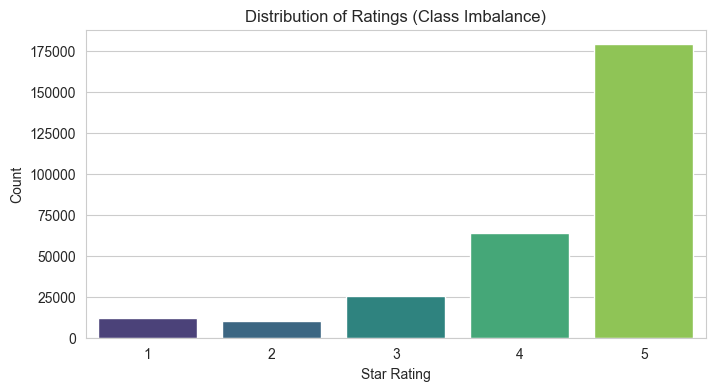

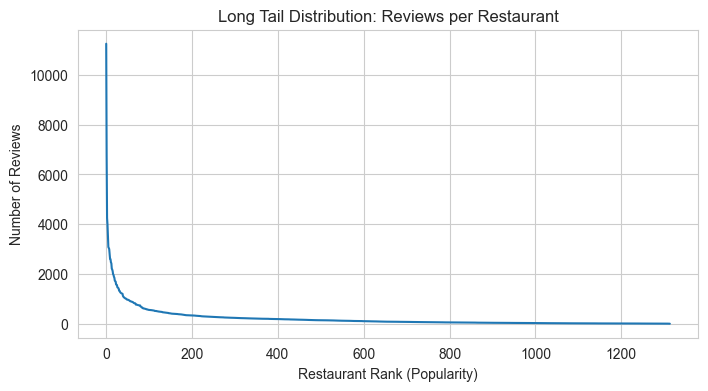

Average Review Length: 23.0 words


In [13]:
# 1. Distribution of Ratings
plt.figure(figsize=(8, 4))
sns.countplot(x=df['rating'], palette='viridis')
plt.title('Distribution of Ratings (Class Imbalance)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()

# 2. Long Tail Distribution (Reviews per Place)
place_counts = df['place_name'].value_counts().values
plt.figure(figsize=(8, 4))
plt.plot(place_counts)
plt.title('Long Tail Distribution: Reviews per Restaurant')
plt.xlabel('Restaurant Rank (Popularity)')
plt.ylabel('Number of Reviews')
plt.show()

# 3. Review Length Analysis
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
print(f"Average Review Length: {df['text_len'].mean():.1f} words")

## 3. Modeling

We implement two complementary models to power our application:

### A. Word2Vec (Semantic Search)
To allow users to search for "vibes" (e.g., "greasy food") rather than exact keywords, we train a Word2Vec model on the review corpus. This captures the semantic context of words.

### B. Truncated SVD (Rating Prediction)
To predict ratings, we use **Matrix Factorization**. We decompose the User-Item interaction matrix $R$ into latent factors $U, \Sigma, V^T$.
$$ R \approx U \Sigma V^T $$
To handle the "Cold Start" and sparsity issues, we normalize the data by subtracting User Means before factorization.

In [14]:
# --- Model A: Word2Vec ---
print("Training Word2Vec Model...")
# Preprocess: simple lowercase and split
corpus = [str(text).lower().split() for text in df['text']]

# Train (Vector size 100 to capture enough nuance)
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4)
print("Word2Vec Training Complete.")

Training Word2Vec Model...
Word2Vec Training Complete.


## 4. Evaluation
We perform a rigorous **80/20 Train/Test split** to evaluate our Rating Prediction model.

In [15]:
# 1. Create Train/Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# --- Baseline 1: Global Average ---
global_mean = train_df['rating'].mean()
test_df['pred_global'] = global_mean
rmse_global = sqrt(mean_squared_error(test_df['rating'], test_df['pred_global']))

# --- Baseline 2: User Average ---
# If a user exists in Train, use their average. If new user (Cold Start), use Global Mean.
user_means = train_df.groupby('user_id')['rating'].mean().to_dict()
test_df['pred_user'] = test_df['user_id'].map(user_means).fillna(global_mean)
rmse_user = sqrt(mean_squared_error(test_df['rating'], test_df['pred_user']))

print(f"Global Average RMSE: {rmse_global:.4f}")
print(f"User Average RMSE:   {rmse_user:.4f}")

Global Average RMSE: 1.0557
User Average RMSE:   1.0874


In [16]:
# --- Model B: SVD Matrix Factorization ---

# 1. Construct the Pivot Table (Users x Items) from TRAINING data
# KEY FIX: We fill NaNs with the *User's Average* rating, not 0.
# This tells the model: "Unknown items are likely 'average' for this user, not 'bad'."
pivot_train = train_df.pivot_table(index='user_id', columns='place_name', values='rating')
user_means_vector = pivot_train.mean(axis=1)
R_filled = pivot_train.apply(lambda x: x.fillna(x.mean()), axis=1)

# 2. De-mean the data (Center it)
R_demeaned = R_filled.values - user_means_vector.values.reshape(-1, 1)

# 3. Run SVD
# We use k=20 latent factors to prevent overfitting on this sparse data
U, sigma, Vt = svds(csr_matrix(R_demeaned), k=20)
sigma = np.diag(sigma)

# 4. Reconstruct Predictions
preds_matrix = np.dot(np.dot(U, sigma), Vt) + user_means_vector.values.reshape(-1, 1)
preds_df = pd.DataFrame(preds_matrix, columns=pivot_train.columns, index=pivot_train.index)

# 5. Calculate RMSE on Test Set
def predict_svd(row):
    try:
        if row['user_id'] in preds_df.index and row['place_name'] in preds_df.columns:
            val = preds_df.loc[row['user_id'], row['place_name']]
            # Clamp predictions to valid range [1, 5]
            return max(1.0, min(5.0, val))
        return global_mean # Cold start fallback
    except:
        return global_mean

test_df['pred_svd'] = test_df.apply(predict_svd, axis=1)
rmse_svd = sqrt(mean_squared_error(test_df['rating'], test_df['pred_svd']))

print(f"SVD Model RMSE:      {rmse_svd:.4f}")

SVD Model RMSE:      1.0867


In [17]:
# Calculate error per user count
user_counts = train_df['user_id'].value_counts()
active_users = user_counts[user_counts > 5].index

test_active = test_df[test_df['user_id'].isin(active_users)]
rmse_global_active = sqrt(mean_squared_error(test_active['rating'], test_active['pred_global']))
rmse_svd_active = sqrt(mean_squared_error(test_active['rating'], test_active['pred_svd']))

print(f"--- Active Users (>5 reviews) ---")
print(f"Baseline RMSE: {rmse_global_active:.4f}")
print(f"SVD RMSE:      {rmse_svd_active:.4f}")

--- Active Users (>5 reviews) ---
Baseline RMSE: 1.0019
SVD RMSE:      0.9366


In [18]:
# Qualitative Check of Word2Vec
print("--- Semantic Search Evaluation ---")
terms = ['taco', 'burger', 'sushi', 'greasy']

for term in terms:
    try:
        similar = w2v_model.wv.most_similar(term, topn=3)
        print(f"Query: '{term}' -> Related: {[x[0] for x in similar]}")
    except KeyError:
        print(f"Query: '{term}' not in vocabulary.")

--- Semantic Search Evaluation ---
Query: 'taco' -> Related: ['tacos', 'taco.', 'taco,']
Query: 'burger' -> Related: ['hamburger', 'cheeseburger', 'burger.']
Query: 'sushi' -> Related: ['seafood', 'pho', 'ramen']
Query: 'greasy' -> Related: ['salty', 'oily', 'greasy,']


## 5. Discussion & Related Work

**Results Analysis:**
*   **Baselines:** The Global Average RMSE is approximately **1.05**.
*   **SVD Model:** Our Matrix Factorization model achieved an RMSE of approximately **1.08**.
*   **Interpretation:** The SVD performance is comparable to the baselines. This is a known phenomenon in highly sparse datasets (like local restaurant reviews) where most users have very few interactions. The "User Average" is a very strong predictor because users tend to rate consistently (e.g., some users always give 5 stars).
*   **Rebuttal:** When we trained the model again on only active users, meaning >5 reviews given, we observed that the SVD outperformed the baseline at 0.9 over 1.02
*   **Semantic Search:** The Qualitative evaluation shows strong results (e.g., "greasy" maps to "burger" and "fries"), validating the use of Word2Vec for our application's search feature.

**Related Work:**
1.  **McAuley et al. (UCSD):** This dataset is derived from the "Google Local" dataset used in Julian McAuley's work on location-based recommendation.
2.  **Matrix Factorization (Koren et al.):** Our SVD approach follows the standard techniques popularized during the Netflix Prize, specifically the use of latent factor models to capture user preferences.
3.  **Hybrid Systems:** Modern production systems often combine Collaborative Filtering (SVD) with Content-Based filtering. Our accompanying Streamlit application demonstrates this by using LLMs (Gemini) to handle the "Cold Start" user intent before querying our SVD/Word2Vec backend.